# Project 4 : West-Nile-Virus-Prediction

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Further Data Cleaning](#Further-Data-Cleaning)
- [EDA](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Data Preparation](#Data-Preparation)
- [Modelling](#Modelling)
- [Submission](#Submission)

# Import Libraries

In [3]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, \
RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [4]:
#steps to install geopandas


#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#pip install contextily

In [5]:
#!pip install imblearn

In [6]:
#!pip install lightgbm

# define some functions

In [7]:
#The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, F1 score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and ROC curve
# 5. plot feature importance list

def run_model(gs, model_name, X_train, y_train, X_test, y_test):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    print("best_params: ")
   # print(gs.best_params_)
    for (item, value) in gs.best_params_.items():
        print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nprecision_recall_auc_score on training set: {train_auc_score:.3f}')
    print(f'precision_recall_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    #calculate the accuracy_score
    train_f1_score =  f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_test_preds)
    f1_perc_diff = np.abs(test_f1_score/train_f1_score*100-100)
    print(f'\nf1_score on training set: {train_f1_score:.3f}')
    print(f'f1_score on testing set: {test_f1_score:.3f}')
    print(f'perc_diff: {f1_perc_diff:.1f} %\n')
    
    
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred No virus', 'pred WnvPresent'], 
                         index=['actual No virus', 'actual WnvPresent'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(gs, X_test, y_test,ax=ax2) 
    
    
    #plot featureimportances
    model = gs.best_estimator_.named_steps["classifier"]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    fig,ax=plt.subplots(1,figsize=(10,20))
    features = X_train.columns
    plt.title('Feature Importances')
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    
    return pd.DataFrame({'Precision_Recall__Auc_Train':train_auc_score,
                         'Precision_Recall_Auc_Test':test_auc_score,
                         'Precision_Recall_Auc Generalization %' : auc_perc_diff,
                         
                         'F1_train' : train_f1_score,
                         'F1_test' : test_f1_score,
                         'F1 Generalization %' : f1_perc_diff
                        }, index=[model_name])


# import data from pickle file

In [8]:
#read pickle_dict, which store everything
pickle_dict2 = pickle.load(open('../assets/data2.pkl', 'rb'))
#df_train = pickle_dict2['df_train']
df_test = pickle_dict2['df_test']
df_final = pickle_dict2['df_final']
df_final_submission = pickle_dict2['df_final_submission']


# Data Preparation

In [9]:
#15, smlgb(public Score: 0.74001), oulgb(Public score: 0.75782)
random_key=15

columns_to_drop = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                            'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'geometry','Station']

X = df_final.drop(columns=columns_to_drop)
y = df_final['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_key, stratify=y)

#for test submission
columns_to_drop_submission = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                            'Latitude', 'Longitude', 'AddressAccuracy', 'geometry','Station', 'Id']

X_submission =  df_final_submission.drop(columns=columns_to_drop_submission)

#result_list to hold the result from each model for final comparison
result_list = []

# Modelling
- oversampling and undersampling
- run model
- evaluate performance

### Model: OverSampling + UnderSampling + GradientBoostingClassifier

best_params: 
    classifier__max_depth  :  2
    classifier__n_estimators  :  300

precision_recall_auc_score on training set: 0.281
precision_recall_auc_score on testing set: 0.255
perc_diff: 9.3 %


f1_score on training set: 0.342
f1_score on testing set: 0.277
perc_diff: 19.0 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2561              426
actual WnvPresent             70               95

plot confusion matrix and ROC curve


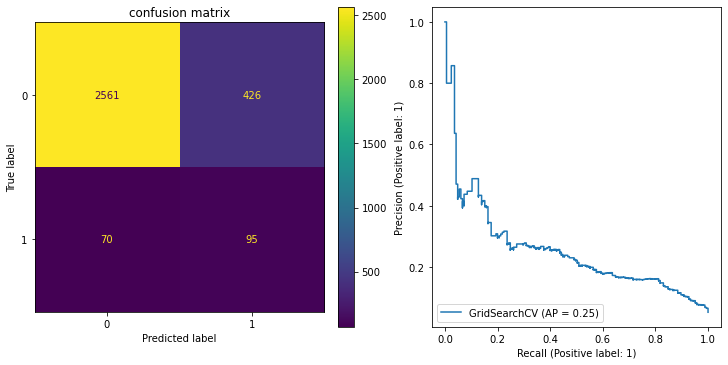

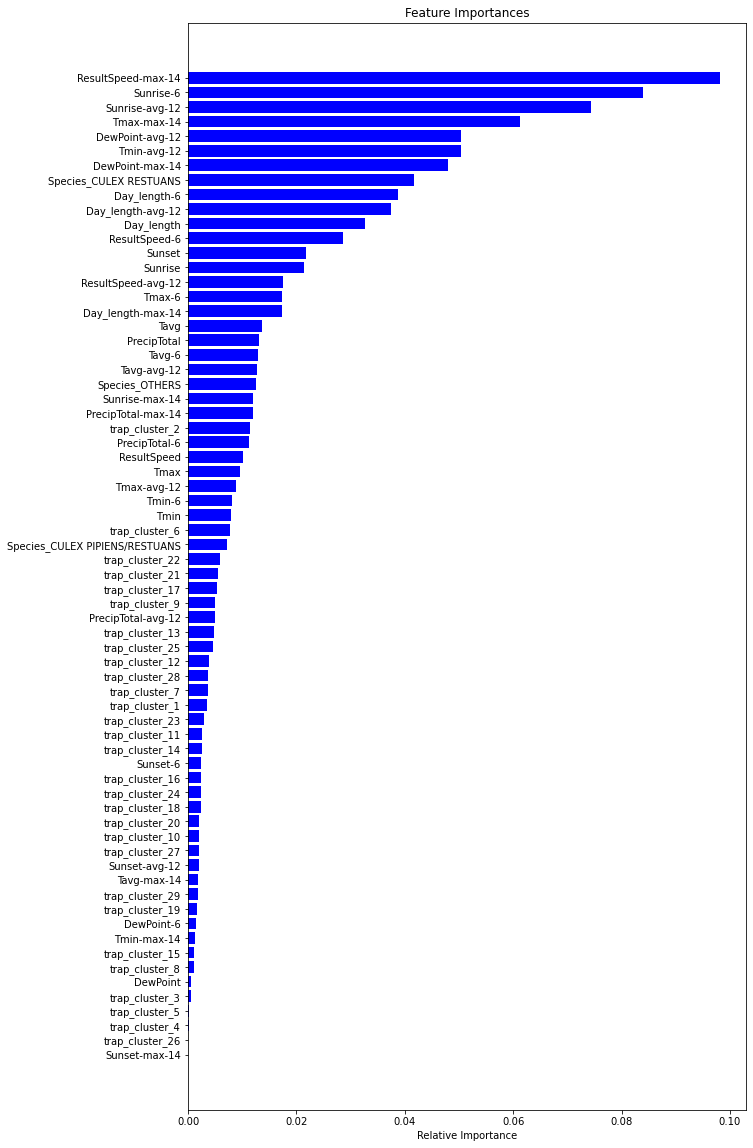

In [11]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = GradientBoostingClassifier(random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300,500],       #The number of trees in the forest.
               'classifier__max_depth' : [2,3,4],              #The maximum depth of the tree.
               }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_ougb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'
                    )


#finding the best hypermeter list for the model
result = run_model(gs_ougb, "OverSampling + UnderSampling + GradientBoost", X_train, y_train, X_test, y_test)
result_list.append(result)


### Model: OverSampling + UnderSampling + RandomForestClassifier

best_params: 
    classifier__class_weight  :  {0: 1, 1: 5}
    classifier__max_depth  :  5
    classifier__n_estimators  :  300

precision_recall_auc_score on training set: 0.209
precision_recall_auc_score on testing set: 0.199
perc_diff: 4.6 %


f1_score on training set: 0.173
f1_score on testing set: 0.163
perc_diff: 5.6 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             1395             1592
actual WnvPresent              9              156

plot confusion matrix and ROC curve


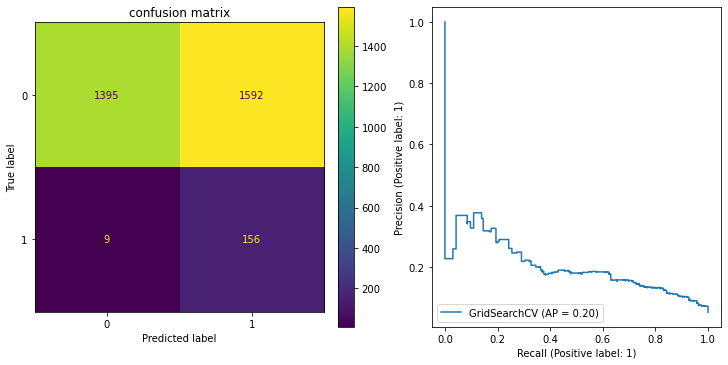

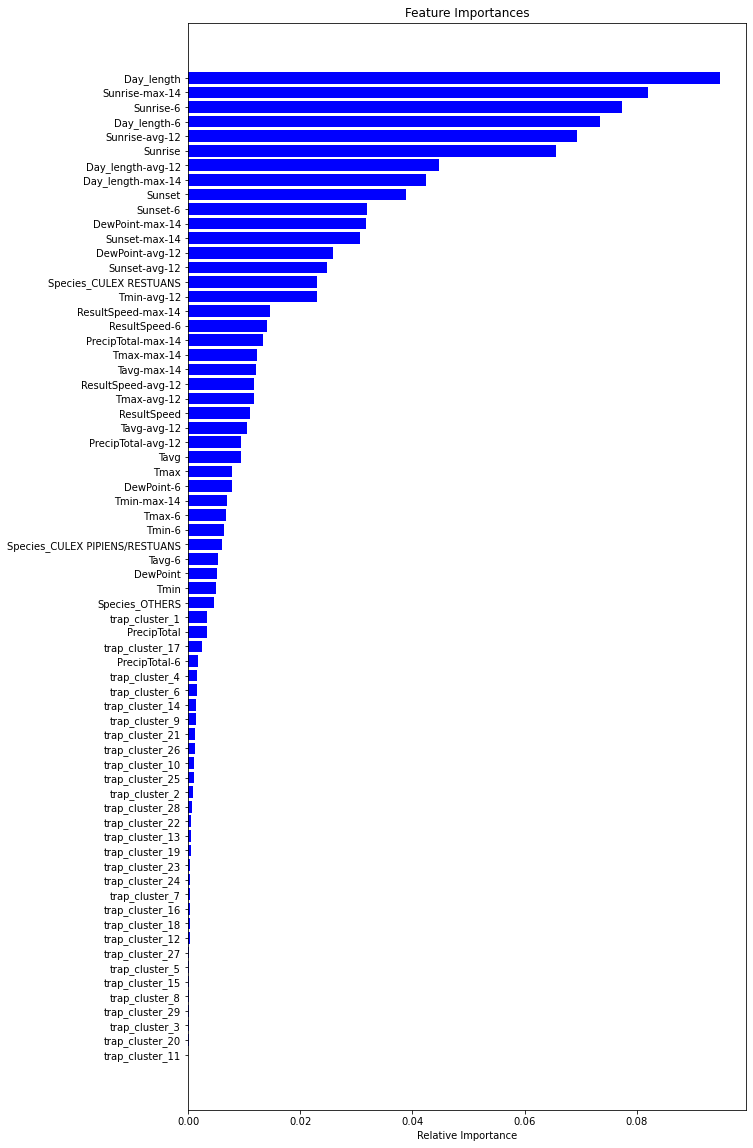

In [12]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = RandomForestClassifier(random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300],       #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
               }


# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_ourf = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'
                    )

#finding the best hypermeter list for the model
result = run_model(gs_ourf, "OverSampling + UnderSampling + RandomForest", X_train, y_train, X_test, y_test )
result_list.append(result)


### Model: OverSampling + UnderSampling + LGBMClassifier

best_params: 
    classifier__learning_rate  :  0.05
    classifier__max_depth  :  5
    classifier__metric  :  auc
    classifier__num_leaves  :  30

precision_recall_auc_score on training set: 0.275
precision_recall_auc_score on testing set: 0.262
perc_diff: 4.7 %


f1_score on training set: 0.321
f1_score on testing set: 0.292
perc_diff: 9.2 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2549              438
actual WnvPresent             62              103

plot confusion matrix and ROC curve


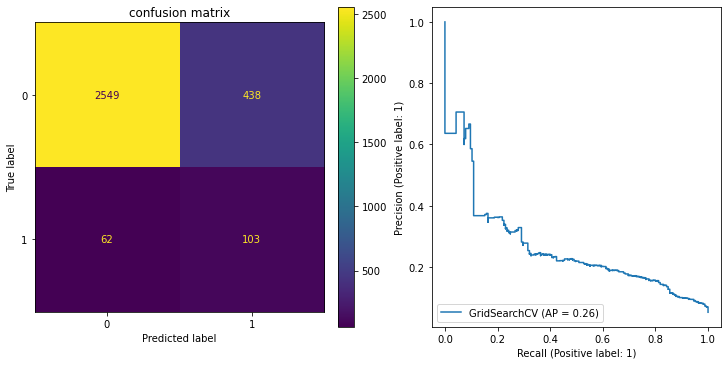

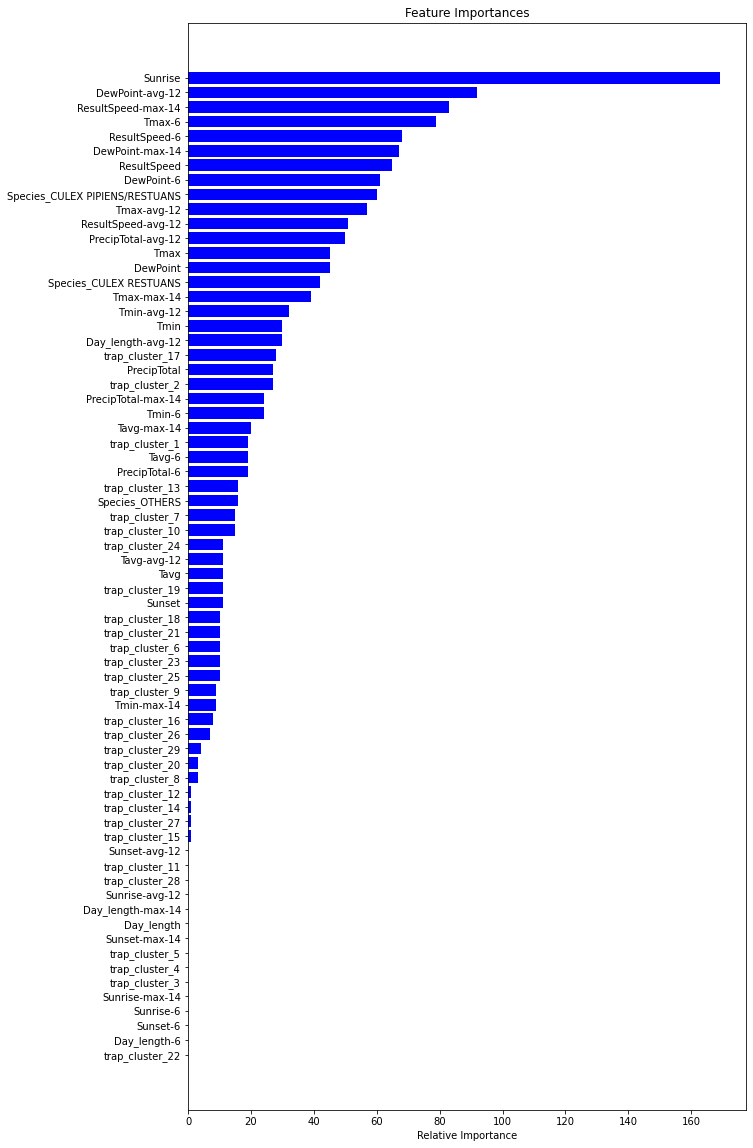

In [13]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = lgb.LGBMClassifier(objective='binary', random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   #The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__metric' : ['auc', 'binary_logloss']              #The maximum depth of the tree.
                }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_oulgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'
                    )

#finding the best hypermeter list for the model
result = run_model(gs_oulgb, "OverSampling + UnderSampling + LightGBM",  X_train, y_train, X_test, y_test )
result_list.append(result)

### Model: SMOTE + LGBMClassifier 

best_params: 
    classifier__learning_rate  :  0.05
    classifier__max_depth  :  6
    classifier__metric  :  auc
    classifier__num_leaves  :  35

precision_recall_auc_score on training set: 0.328
precision_recall_auc_score on testing set: 0.307
perc_diff: 6.7 %


f1_score on training set: 0.313
f1_score on testing set: 0.316
perc_diff: 1.0 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus             2923               64
actual WnvPresent            122               43

plot confusion matrix and ROC curve


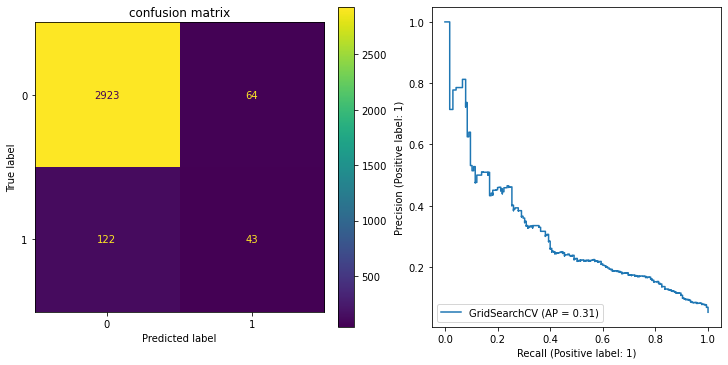

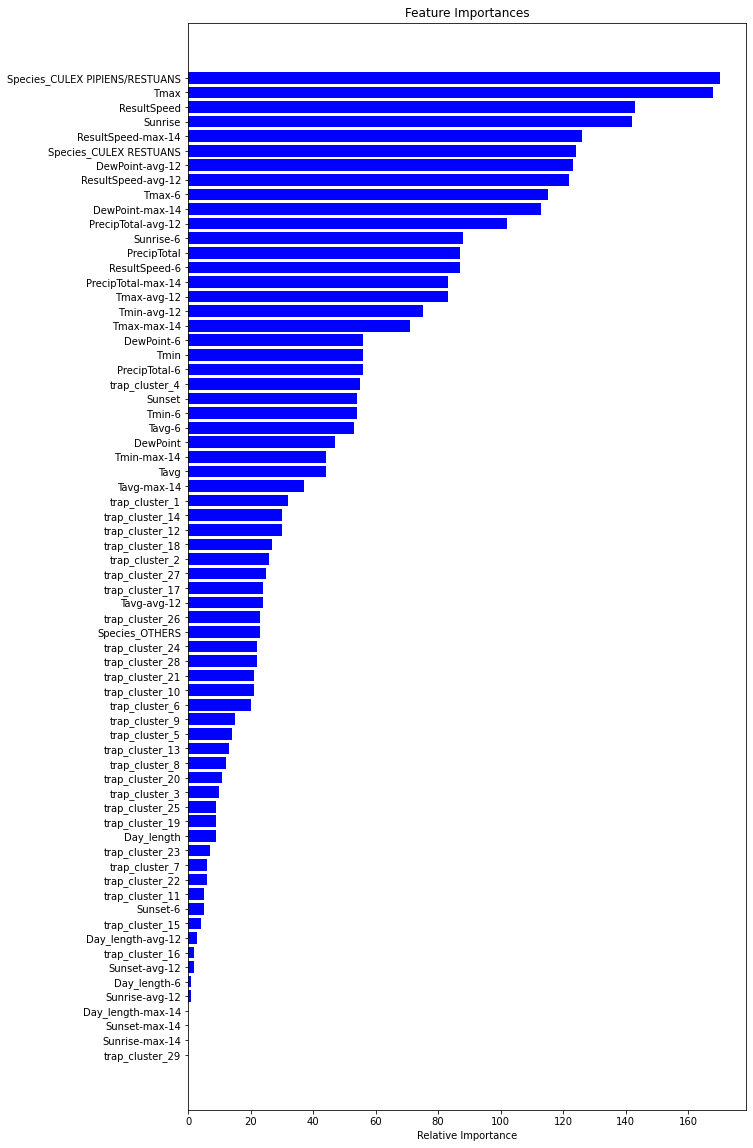

In [14]:
# define pipeline
#over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.2, random_state=random_key)

model = lgb.LGBMClassifier(objective='binary', random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   #The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__metric' : ['auc', 'binary_logloss']              #The maximum depth of the tree.
                }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_smlgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'
                    )

#finding the best hypermeter list for the model
result = run_model(gs_smlgb, "SMOTE + LightGBM",  X_train, y_train, X_test, y_test )
result_list.append(result)

# Model performance comparison

In [15]:
result_final= pd.concat(result_list,axis=0)
result_final

,Precision_Recall__Auc_Train,Precision_Recall_Auc_Test,Precision_Recall_Auc Generalization %,F1_train,F1_test,F1 Generalization %
OverSampling + UnderSampling + GradientBoost,0.28,0.25,9.33,0.34,0.28,18.95
OverSampling + UnderSampling + RandomForest,0.21,0.20,4.59,0.17,0.16,5.62
OverSampling + UnderSampling + LightGBM,0.28,0.26,4.67,0.32,0.29,9.15
SMOTE + LightGBM,0.33,0.31,6.67,0.31,0.32,0.96


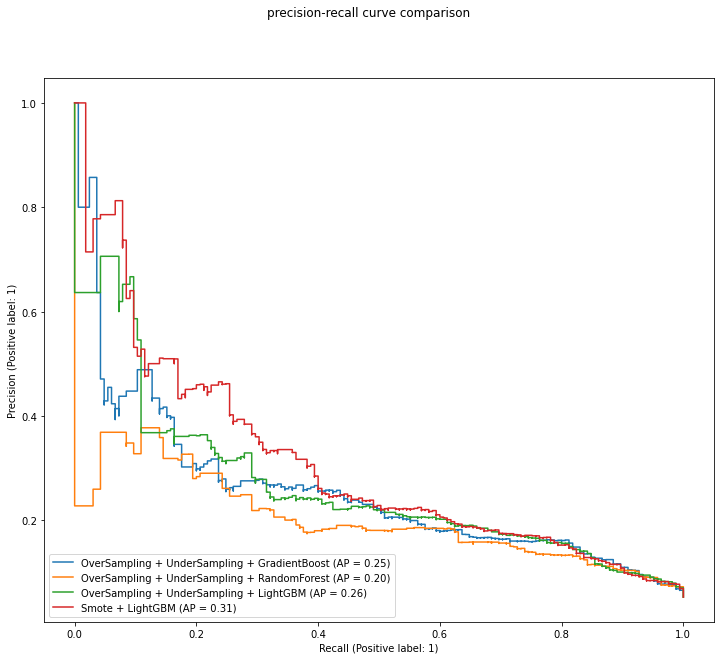

In [16]:
# Comparing precision-recall curve
plt.rcParams['figure.figsize'] = (12.0, 10.0)
#plot ROC curve
fig=PrecisionRecallDisplay.from_estimator(gs_ougb, X_test, y_test,name="OverSampling + UnderSampling + GradientBoost") 
PrecisionRecallDisplay.from_estimator(gs_ourf, X_test, y_test, name='OverSampling + UnderSampling + RandomForest',ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_oulgb, X_test, y_test, name='OverSampling + UnderSampling + LightGBM',ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_smlgb, X_test, y_test, name='Smote + LightGBM',ax = fig.ax_) 
fig.figure_.suptitle("precision-recall curve comparison")
plt.show()

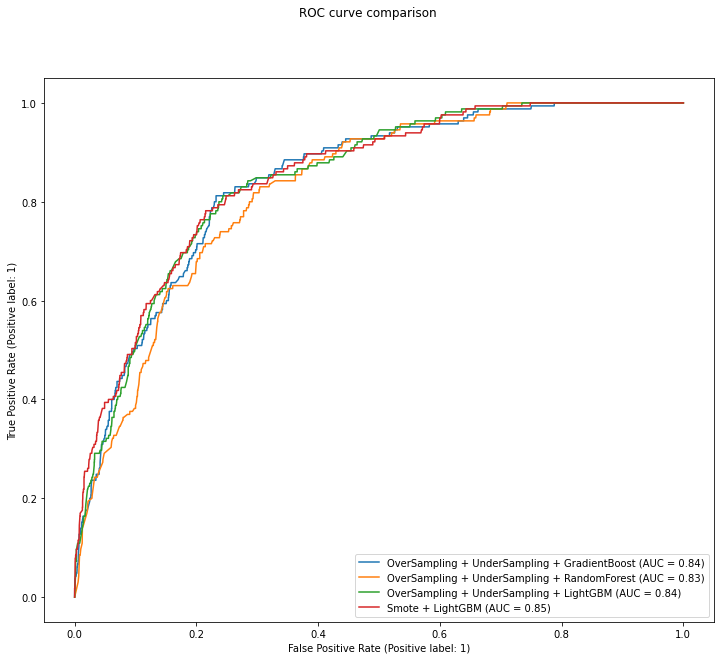

In [17]:
# Comparing ROC AUC
plt.rcParams['figure.figsize'] = (12.0, 10.0)
#plot ROC curve
fig=RocCurveDisplay.from_estimator(gs_ougb, X_test, y_test,name="OverSampling + UnderSampling + GradientBoost") 
RocCurveDisplay.from_estimator(gs_ourf, X_test, y_test, name='OverSampling + UnderSampling + RandomForest',ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_oulgb, X_test, y_test, name='OverSampling + UnderSampling + LightGBM',ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_smlgb, X_test, y_test, name='Smote + LightGBM',ax = fig.ax_) 
fig.figure_.suptitle("ROC curve comparison")
plt.show()

# Submission

<AxesSubplot:xlabel='WnvPresent', ylabel='Count'>

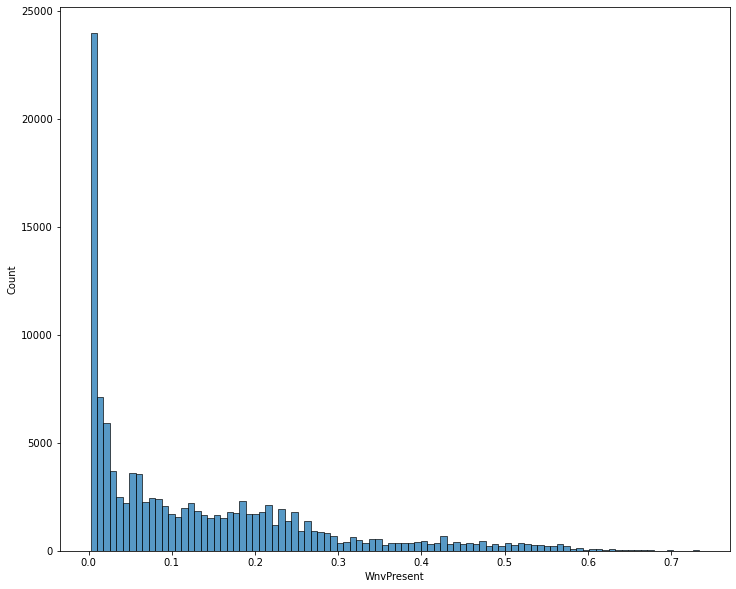

In [20]:
WnvPresent_prob_list = gs_oulgb.predict_proba(X_submission)
df_test['WnvPresent'] = [list(t) for t in zip(*WnvPresent_prob_list)][1]
df_submission=df_test[['Id','WnvPresent']]
df_submission.to_csv("../assets/submission.csv",index=False)
sns.histplot(df_submission['WnvPresent'])